In [2]:
import sys
import os
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!git clone https://github.com/maximus3343/movie-rec

Cloning into 'movie-rec'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 126.07 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [4]:
cloned_repo_path = '/content/movie-rec'

if cloned_repo_path not in sys.path:
    sys.path.append(cloned_repo_path)
print(f"Added {cloned_repo_path} to sys.path")

Added /content/movie-rec to sys.path


In [5]:
import pandas as pd

from MovieEnv import MovieEnv
from PPO import PPO
from Buffer import Experience

In [6]:
path = kagglehub.dataset_download("vodclickstream/netflix-audience-behaviour-uk-movies")
dataset_name = os.listdir(path)[0]
path = os.path.join(path, dataset_name)

100%|██████████| 18.1M/18.1M [00:00<00:00, 168MB/s]

Extracting files...


Here are the performances of the DRL based on my custom Movie-Rec environment. Even with the high action space, the agent is able to recommend movies with high watch time (based on dataset) and good entropy to the user.

Complex network, with environment only focusing on average watch time, not entropy of recently watched movies

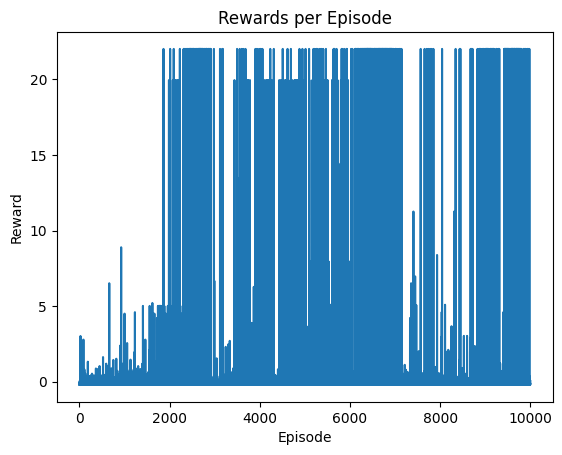

In [17]:
# Higher number of paramters used.
def main():
    df = pd.read_csv(path)
    N = 4  # Number of last movies watched kept as state.
    envi = MovieEnv(df, N=N, alpha=1, beta=0)

    lr = 1e-4  # Same learning rate for all modules.
    gamma = 0.95  # Discount factor.
    in_features = 128
    hidden_size = 256
    embedding_dim = 64
    id_list = df['movie_id'].unique()  # List of movies.
    K_epochs = 5
    eps_clip = 0.2
    top_k = 0

    a = PPO(in_features=in_features, out_features=envi.action_space.n, hidden_size=hidden_size, embedding_dim=embedding_dim, lr_actor=lr,
            lr_critic=lr, lr_sr=lr, gamma=gamma, N=N, K_epochs=K_epochs, eps_clip=eps_clip, movie_id_list=id_list, top_k=top_k,
            algo='monte_carlo')

    episodes = 10000
    rewards = []

    for k in range(episodes):
        state, info = envi.reset()
        done = False

        total_reward = 0

        while not done:
            action, state_value, action_logprob = a.select_action(state)
            next_state, reward, done, _, _ = envi.step(action)

            # exp = Experience(state, action, reward, next_state, done, state_value, action_logprob)
            a.add_experience(Experience(state, action, reward,
                            next_state, done, state_value, action_logprob))

            total_reward += reward

            state = next_state

        a.learn()
        rewards.append(reward)

    return rewards

if __name__ == "__main__":
    rewards = main()
    plt.plot(np.arange(len(rewards)), rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")



Complex network, with environment rewarding both watch time and entropy of the recently watched movies

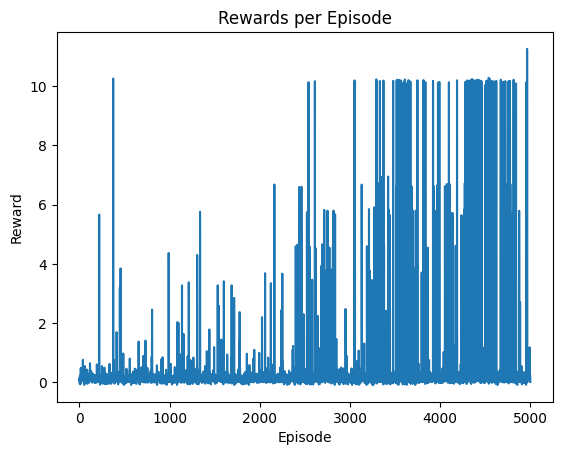

In [18]:
# Higher number of paramters used.
# Entropy used to compute reward inside environment.
def main():
    df = pd.read_csv(path)
    N = 4  # Number of last movies watched kept as state.
    envi = MovieEnv(df, N=N, alpha=0.5, beta=0.5)

    lr = 1e-4  # Same learning rate for all modules.
    gamma = 0.95  # Discount factor.
    in_features = 128
    hidden_size = 256
    embedding_dim = 64
    id_list = df['movie_id'].unique()  # List of movies.
    K_epochs = 5
    eps_clip = 0.2
    top_k = 0

    a = PPO(in_features=in_features, out_features=envi.action_space.n, hidden_size=hidden_size, embedding_dim=embedding_dim, lr_actor=lr,
            lr_critic=lr, lr_sr=lr, gamma=gamma, N=N, K_epochs=K_epochs, eps_clip=eps_clip, movie_id_list=id_list, top_k=top_k,
            algo='monte_carlo')

    episodes = 5000
    rewards = []

    for k in range(episodes):
        state, info = envi.reset()
        done = False

        total_reward = 0

        while not done:
            action, state_value, action_logprob = a.select_action(state)
            next_state, reward, done, _, _ = envi.step(action)

            # exp = Experience(state, action, reward, next_state, done, state_value, action_logprob)
            a.add_experience(Experience(state, action, reward,
                            next_state, done, state_value, action_logprob))

            total_reward += reward

            state = next_state

        a.learn()
        rewards.append(reward)

    return rewards

if __name__ == "__main__":
    rewards = main()
    plt.plot(np.arange(len(rewards)), rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")



Simpler network, with environment rewarding both watch time and entropy of the recently watched movies. No learning after 4000 episodes.

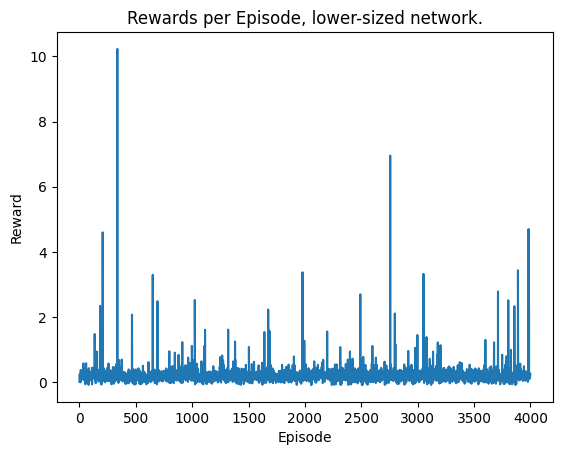

In [7]:
# Lower-sized network.
def main():
    df = pd.read_csv(path)
    N = 6  # Number of last movies watched kept as state.
    envi = MovieEnv(df, N=N, alpha=0.5, beta=0.5)

    lr = 1e-4  # Same learning rate for all modules.
    gamma = 0.95  # Discount factor.
    in_features = 32
    hidden_size = 64
    embedding_dim = 16
    id_list = df['movie_id'].unique()  # List of movies.
    K_epochs = 5
    eps_clip = 0.2
    top_k = 0 # Still no top-k sampling.

    a = PPO(in_features=in_features, out_features=envi.action_space.n, hidden_size=hidden_size, embedding_dim=embedding_dim, lr_actor=lr,
            lr_critic=lr, lr_sr=lr, gamma=gamma, N=N, K_epochs=K_epochs, eps_clip=eps_clip, movie_id_list=id_list, top_k=top_k,
            algo='monte_carlo')

    episodes = 4000
    rewards = []

    for k in range(episodes):
        state, info = envi.reset()
        done = False

        total_reward = 0

        while not done:
            action, state_value, action_logprob = a.select_action(state)
            next_state, reward, done, _, _ = envi.step(action)

            # exp = Experience(state, action, reward, next_state, done, state_value, action_logprob)
            a.add_experience(Experience(state, action, reward,
                            next_state, done, state_value, action_logprob))

            total_reward += reward

            state = next_state

        a.learn()
        rewards.append(reward)

    return rewards

if __name__ == "__main__":
    rewards = main()
    plt.plot(np.arange(len(rewards)), rewards)
    plt.title("Rewards per Episode, lower-sized network.")
    plt.xlabel("Episode")
    plt.ylabel("Reward")



The project aims to train an intelligent agent to recommend movies to a simulated user. It frames the movie recommendation task as a MDP using a custom environment based on a static dataset, Netflix Behaviour in the UK. However, the environement is very limited, and does not really replicate the behaviour of a real user.

I first designed a custom environment that simulates a user's movie watching session based on a dataset. It provides a reward based on factors such as watch time or genre diversity of the watched sequences. At each time step, the agent (user) selects a movie. The environment will then return a sequence of recently watched movies (in order), and provide a reward.

The agent is composed of two main modules. The first one is the StateRep, it is responsible to transform the variable-length sequence of movie ID's returned by env into a fixed-size feature vector which could be used by a neural network. Each movie ID is first represented by an embedding layer. Since the state is a sequence, the latest StateRep module provided here uses a LSTM to analyze the data (embeddings) and capture dependencies over time. Then, a Linear network outputs the fixed-size numerical vector representation.

Then, we have the ActorCritic module. This module was initially created to perform well on the Cartpole environment, providing a good framework to begin with. It has two heads, Actor which outputs a stochastic policy over the set of movies (actions), and Critic that estimates the value of the current state.

These two modules are then combined inside the PPO agent, which implements the proximal policy optimization algorithm from OpenAI. It first uses the StateRep to analyze the state and output a feature vector. The ActorCritic module is then used to select the action and evaluate the state provided by StateRep. PPO also collects the experiences in the Buffer, and updates the StateRep and ActorCritic by optimizing a clipped surrogate objective over multiple k_epochs.

I initially got poor performances out of the PPO agent. I tested the agent with higher number of parameters, but the higher complexity did not help the learning. The shapes of the Tensors were also checked at every step, ensuring that the proper computation was performed. Hence, I modified my initial StateRep module, now deprecated, and implemented an LSTM layer instead. The new modules, with proper tensor shapes have fixed my DRL performance. I did implement some regularization techniques such as some dropout layers inside the ActorCritic module, but I really don't think overfitting is an issue here.

There are still two main issues. As pointed out by the teacher, I underestimated how hard it would be to estimate properly the reward for a movie recommendation system. I tried building out a live system from a static dataset, and providing an environment for the agent to learn, but it's still very barebone and far from reality. I've put a small probability at each movie watched that the session ends, but in reality the user would stop if the recommendations are not good. The reward is also very subjective, and could be interpreted much differently from what I have done. The state from the environment should be modified as well to include some user info, but I assumed that the agent would just be fined-tune for each user. By training a separate agent for each individual user, the DRL would effectively learn the preferences and characteristics, without the need of a modified state. There is also the problem of the action space. If a new movie is added on the platform, there is no direct way to add it to the DRL's action space. We would need either transfer learning, or meta-learning to accomodate the issue, but I think this is out of the scope for this project.
